In [112]:
import pkg_resources
import requests
import json
import time
from datetime import datetime

# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date

#Import Model Packages 
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from sklearn.linear_model import LinearRegression

#Package for optimization of mean variance optimization
import cvxopt as opt
from cvxopt import blas, solvers

#Import Model Packages 
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import inv, eig, svd

from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA
from scipy.stats import pearsonr

# Loading Data Set and Seperating into Treasury and Token Data Sets

In [2]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/kinji20/crypto/main/bq-results-20211123-152806-sskof95w50gb.csv')
raw_data['Date'] = pd.to_datetime(raw_data['block_timestamp']).dt.date
raw_data['value'] = raw_data['value'].astype(float)
raw_data

,token_address,from_address,to_address,value,transaction_hash,log_index,block_timestamp,block_number,block_hash,Date
0,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xd7c4208aeb0961972b3ea717be25f2194d5f0331,6.826000e+13,0xf488c488a0b243eed720ebd4531c439caaa1abfd98c9...,184,2021-03-22 01:27:44 UTC,12085665,0x2bcec7d248ef11af703e3bc3e29c68ea56a5a097460b...,2021-03-22
1,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xeec0deeac0ac7e9c8b50e2153afa5ae9f3a13e17,1.000000e+09,0x39b08a0b9242ae23282df3f1c64fd36af094a6a812d8...,220,2021-03-25 00:49:22 UTC,12104978,0xc5efdec864f4c50da95fb8261576229f81ad7f352274...,2021-03-25
2,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xeec0deeac0ac7e9c8b50e2153afa5ae9f3a13e17,2.730440e+11,0x51135b52c65a92872a7bf11542f5facd5752345e4cb0...,132,2021-03-25 02:40:48 UTC,12105446,0x4148d91f28c87171326b07449a967acc68a089cee2a6...,2021-03-25
3,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xeec0deeac0ac7e9c8b50e2153afa5ae9f3a13e17,6.853404e+09,0xbfa2a2ec5779476d935173fe2044d49be55316d0c97c...,77,2021-03-25 02:51:07 UTC,12105496,0xa387a194e212e74f48241287c3fc929aa26717369dd6...,2021-03-25
4,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xeec0deeac0ac7e9c8b50e2153afa5ae9f3a13e17,2.000000e+10,0x9685362977fb1d7ba6443a74330d8f59dff9088d2e97...,77,2021-03-25 03:21:30 UTC,12105628,0x9004789cdc8facd24c1a5a14d5f368a6398a66227694...,2021-03-25
...,...,...,...,...,...,...,...,...,...,...
15987,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xfec8054a38e78627d44144f325ae701dd51065cc,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,1.000000e+18,0xf051f02bedd059f13fc18edc0e37eb8e99e136479ae3...,502,2021-11-23 14:34:06 UTC,13671399,0x4c8e580a41f9f32bd63984d698dca7f28be22a4902e3...,2021-11-23
15988,0x6b175474e89094c44da98b954eedeac495271d0f,0x575409f8d77c12b05fed8b455815f0e54797381c,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,3.825166e+20,0x1d0e89f00973944b7047339119a196d01625790c01dc...,136,2021-11-23 14:49:14 UTC,13671459,0x0c74fb72cbf7767fb618d2d6f00cddf88592516cec21...,2021-11-23
15989,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0x575409f8d77c12b05fed8b455815f0e54797381c,6.952129e+08,0x1d0e89f00973944b7047339119a196d01625790c01dc...,137,2021-11-23 14:49:14 UTC,13671459,0x0c74fb72cbf7767fb618d2d6f00cddf88592516cec21...,2021-11-23
15990,0xc770eefad204b5180df6a14ee197d99d808ee52d,0x270689eeefac9015ea8ea3c1c082f91af2a7f77c,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,1.244255e+21,0xf1dcd20d377007c0af0fa4d044692fa06044a7f48f2e...,103,2021-11-23 15:02:29 UTC,13671525,0xdda012d1c938858998a584719dcef5fc005212cb32a9...,2021-11-23


In [3]:
treasury_data = raw_data[(raw_data["from_address"] == '0x31f8cc382c9898b273eff4e0b7626a6987c846e8') | (raw_data["to_address"] == '0x31f8cc382c9898b273eff4e0b7626a6987c846e8')]
treasury_data['value'] = treasury_data['value'] / (1000000000000000000)
treasury_data

<ipython-input-3-f90876e3e071>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treasury_data['value'] = treasury_data['value'] / (1000000000000000000)


,token_address,from_address,to_address,value,transaction_hash,log_index,block_timestamp,block_number,block_hash,Date
891,0x6b175474e89094c44da98b954eedeac495271d0f,0x763a641383007870ae96067818f1649e5586f6de,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,1.009029e+02,0xe23900ee9134d155c0f95fca6d138f6d9c98af90c5c3...,300,2021-05-29 17:21:09 UTC,12530585,0xe95c5b64dfff5a71da13d0cb65482b5c5180b91a7595...,2021-05-29
893,0x6b175474e89094c44da98b954eedeac495271d0f,0x245cc372c84b3645bf0ffe6538620b04a217988b,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,3.370301e+06,0x017e4e5c991c8b4c64d301dadfea23767f158eb4bec4...,50,2021-05-29 23:38:43 UTC,12532291,0x82268c3bfa5717bab0d6dae3d20d9a1b5d6044d86d8a...,2021-05-29
894,0x34d7d7aaf50ad4944b70b320acb24c95fa2def7c,0x245cc372c84b3645bf0ffe6538620b04a217988b,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,1.175000e+01,0xac796de8729b03f91deea94fb8894eae68a20dc11520...,42,2021-05-29 23:45:43 UTC,12532321,0x444f3c52ecd962310a2e2688191104300e79d12cc476...,2021-05-29
914,0x6b175474e89094c44da98b954eedeac495271d0f,0xd03056323b7a63e2095ae97fa1ad92e4820ff045,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,4.500000e+03,0x209e41c3f0aafed7cef0601e26b00a789dc200c44176...,59,2021-06-01 21:20:22 UTC,12550991,0xf1ca1628e8d4f5df27abfcf8b796f7eb7b4f000a1548...,2021-06-01
916,0x6b175474e89094c44da98b954eedeac495271d0f,0xd03056323b7a63e2095ae97fa1ad92e4820ff045,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,4.500000e+03,0xc2ce59ad653a0984a297331aa97193cbd474b84d746d...,275,2021-06-01 21:22:06 UTC,12550997,0xcf6991463b8b36c8d172c5fac7620416b5aff7411ae7...,2021-06-01
...,...,...,...,...,...,...,...,...,...,...
15985,0xdbdb4d16eda451d0503b854cf79d55697f90c8df,0x1e5b7412f4b4b713b93d0e82260bd27810984b6e,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,1.037039e+00,0x545bfc8aa362348b561539ad6d5046ecc475dabe1d44...,73,2021-11-23 13:59:14 UTC,13671252,0x544d3ddeb63fcda6e593f8cd442e484777fe8e366e95...,2021-11-23
15987,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xfec8054a38e78627d44144f325ae701dd51065cc,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,1.000000e+00,0xf051f02bedd059f13fc18edc0e37eb8e99e136479ae3...,502,2021-11-23 14:34:06 UTC,13671399,0x4c8e580a41f9f32bd63984d698dca7f28be22a4902e3...,2021-11-23
15988,0x6b175474e89094c44da98b954eedeac495271d0f,0x575409f8d77c12b05fed8b455815f0e54797381c,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,3.825166e+02,0x1d0e89f00973944b7047339119a196d01625790c01dc...,136,2021-11-23 14:49:14 UTC,13671459,0x0c74fb72cbf7767fb618d2d6f00cddf88592516cec21...,2021-11-23
15990,0xc770eefad204b5180df6a14ee197d99d808ee52d,0x270689eeefac9015ea8ea3c1c082f91af2a7f77c,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,1.244255e+03,0xf1dcd20d377007c0af0fa4d044692fa06044a7f48f2e...,103,2021-11-23 15:02:29 UTC,13671525,0xdda012d1c938858998a584719dcef5fc005212cb32a9...,2021-11-23


In [4]:
token_data = raw_data[(raw_data["from_address"] == '0x383518188c0c6d7730d91b2c03a03c837814a899') | (raw_data["to_address"] == '0x383518188c0c6d7730d91b2c03a03c837814a899')]
token_data

,token_address,from_address,to_address,value,transaction_hash,log_index,block_timestamp,block_number,block_hash,Date
0,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xd7c4208aeb0961972b3ea717be25f2194d5f0331,6.826000e+13,0xf488c488a0b243eed720ebd4531c439caaa1abfd98c9...,184,2021-03-22 01:27:44 UTC,12085665,0x2bcec7d248ef11af703e3bc3e29c68ea56a5a097460b...,2021-03-22
1,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xeec0deeac0ac7e9c8b50e2153afa5ae9f3a13e17,1.000000e+09,0x39b08a0b9242ae23282df3f1c64fd36af094a6a812d8...,220,2021-03-25 00:49:22 UTC,12104978,0xc5efdec864f4c50da95fb8261576229f81ad7f352274...,2021-03-25
2,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xeec0deeac0ac7e9c8b50e2153afa5ae9f3a13e17,2.730440e+11,0x51135b52c65a92872a7bf11542f5facd5752345e4cb0...,132,2021-03-25 02:40:48 UTC,12105446,0x4148d91f28c87171326b07449a967acc68a089cee2a6...,2021-03-25
3,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xeec0deeac0ac7e9c8b50e2153afa5ae9f3a13e17,6.853404e+09,0xbfa2a2ec5779476d935173fe2044d49be55316d0c97c...,77,2021-03-25 02:51:07 UTC,12105496,0xa387a194e212e74f48241287c3fc929aa26717369dd6...,2021-03-25
4,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xeec0deeac0ac7e9c8b50e2153afa5ae9f3a13e17,2.000000e+10,0x9685362977fb1d7ba6443a74330d8f59dff9088d2e97...,77,2021-03-25 03:21:30 UTC,12105628,0x9004789cdc8facd24c1a5a14d5f368a6398a66227694...,2021-03-25
...,...,...,...,...,...,...,...,...,...,...
15977,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xe6295201cd1ff13ced5f063a5421c39a1d236f1c,7.696008e+08,0xfc90dde9324f207f3398673ead2b8460e6a5c3944387...,289,2021-11-23 10:47:20 UTC,13670396,0xc8708c325541eef7f02bf4d6df4f5322ef166e9551a1...,2021-11-23
15982,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xfd31c7d00ca47653c6ce64af53c1571f9c36566a,1.705360e+13,0xea517568dc45ce63e37485af2f3e48693c91fb4d96c8...,3,2021-11-23 12:19:40 UTC,13670800,0xfc6f5cb3b7741b6cc950d33fe1c702fb065d2d31e45a...,2021-11-23
15984,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xe6295201cd1ff13ced5f063a5421c39a1d236f1c,6.521160e+10,0x59d03cb0aa17489edbc5c447b2f9e4e2e78b1a75249e...,542,2021-11-23 13:54:25 UTC,13671236,0x81d31ad3edb5d9d30f9a410acd5ded1857e9450e1559...,2021-11-23
15986,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xe6295201cd1ff13ced5f063a5421c39a1d236f1c,4.923683e+09,0xf051f02bedd059f13fc18edc0e37eb8e99e136479ae3...,503,2021-11-23 14:34:06 UTC,13671399,0x4c8e580a41f9f32bd63984d698dca7f28be22a4902e3...,2021-11-23


# Treasury Data Analysis

## Finding All Tokens in Treasury

In [5]:
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0x6b175474e89094c44da98b954eedeac495271d0f', 'DAI', treasury_data["token_address"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0x34d7d7aaf50ad4944b70b320acb24c95fa2def7c', 'OHM-DAI', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0x2dce0dda1c2f98e0f171de8333c3c6fe1bbf4877', 'OHM-FRAX', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0x853d955acef822db058eb8505911ed77f175b99e', 'FRAX', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0x8798249c2e607446efb7ad49ec89dd1865ff4272', 'xSushi', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0x4da27a545c0c5b758a6ba100e3a049001de870f5', 'stkAAVE', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', 'wETH', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0xd533a949740bb3306d119cc777fa900ba034cd52', 'CRV', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0x3432b6a60d23ca0dfca7761b7ab56459d9c964d0', 'FXS', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0x4e3fbd56cd56c3e72c1403e103b45db9da5b9d2b', 'CVX', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0x5f98805a4e8be255a32880fdec7f6728c6568ba0', 'LUSD', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0x808507121b80c02388fad14726482e061b8da827', 'PENDLE', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0x090185f2135308bad17527004364ebcc2d37e5f6', 'SPELL', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0xac14864ce5a98af3248ffbf549441b04421247d3', 'xSDT', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0xdbdb4d16eda451d0503b854cf79d55697f90c8df', 'ALCX', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0x24a6a37576377f63f194caa5f518a60f45b42921', 'BANK', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0xfdf12d1f85b5082877a6e070524f50f6c84faa6b', 'SLP', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0xc770eefad204b5180df6a14ee197d99d808ee52d', 'FOX', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0xfffae4a0f4ac251f4705717cd24cadccc9f33e06', 'OHM-ETH', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0x0f2d719407fdbeff09d87557abb7232601fd9f29', 'SYN', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0x69fa0fee221ad11012bab0fdb45d444d3d2ce71c', 'XRUNE', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0x41d5d79431a913c4ae7d69a668ecdfe5ff9dfb68', 'INV', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0x0391d2021f89dc339f60fff84546ea23e337750f', 'BOND', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0x0cec1a9154ff802e7934fc916ed7ca50bde6844e', 'POOL', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0x6399c842dd2be3de30bf99bc7d1bbf6fa3650e70', 'PREMIA', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0xfa5047c9c78b8877af97bdcb85db743fd7313d4a', 'ROOK', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0xa3bed4e1c75d00fa6f4e5e6922db7261b5e9acd2', 'MTA', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0x2d94aa3e47d9d5024503ca8491fce9a2fb4da198', 'BANK', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0x31429d1856ad1377a8a0079410b297e1a9e214c2', 'ANGLE', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0x3ec8798b81485a254928b70cda1cf0a2bb0b74d7', 'GRO', treasury_data["token_symbol"])
treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0x579cea1889991f68acc35ff5c3dd0621ff29b0c9', 'IQ', treasury_data["token_symbol"])
treasury_data

<ipython-input-5-8f4bd0eb2e5e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0x6b175474e89094c44da98b954eedeac495271d0f', 'DAI', treasury_data["token_address"])
<ipython-input-5-8f4bd0eb2e5e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treasury_data["token_symbol"] = np.where(treasury_data["token_address"] == '0x34d7d7aaf50ad4944b70b320acb24c95fa2def7c', 'OHM-DAI', treasury_data["token_symbol"])
<ipython-input-5-8f4bd0eb2e5e

,token_address,from_address,to_address,value,transaction_hash,log_index,block_timestamp,block_number,block_hash,Date,token_symbol
891,0x6b175474e89094c44da98b954eedeac495271d0f,0x763a641383007870ae96067818f1649e5586f6de,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,1.009029e+02,0xe23900ee9134d155c0f95fca6d138f6d9c98af90c5c3...,300,2021-05-29 17:21:09 UTC,12530585,0xe95c5b64dfff5a71da13d0cb65482b5c5180b91a7595...,2021-05-29,DAI
893,0x6b175474e89094c44da98b954eedeac495271d0f,0x245cc372c84b3645bf0ffe6538620b04a217988b,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,3.370301e+06,0x017e4e5c991c8b4c64d301dadfea23767f158eb4bec4...,50,2021-05-29 23:38:43 UTC,12532291,0x82268c3bfa5717bab0d6dae3d20d9a1b5d6044d86d8a...,2021-05-29,DAI
894,0x34d7d7aaf50ad4944b70b320acb24c95fa2def7c,0x245cc372c84b3645bf0ffe6538620b04a217988b,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,1.175000e+01,0xac796de8729b03f91deea94fb8894eae68a20dc11520...,42,2021-05-29 23:45:43 UTC,12532321,0x444f3c52ecd962310a2e2688191104300e79d12cc476...,2021-05-29,OHM-DAI
914,0x6b175474e89094c44da98b954eedeac495271d0f,0xd03056323b7a63e2095ae97fa1ad92e4820ff045,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,4.500000e+03,0x209e41c3f0aafed7cef0601e26b00a789dc200c44176...,59,2021-06-01 21:20:22 UTC,12550991,0xf1ca1628e8d4f5df27abfcf8b796f7eb7b4f000a1548...,2021-06-01,DAI
916,0x6b175474e89094c44da98b954eedeac495271d0f,0xd03056323b7a63e2095ae97fa1ad92e4820ff045,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,4.500000e+03,0xc2ce59ad653a0984a297331aa97193cbd474b84d746d...,275,2021-06-01 21:22:06 UTC,12550997,0xcf6991463b8b36c8d172c5fac7620416b5aff7411ae7...,2021-06-01,DAI
...,...,...,...,...,...,...,...,...,...,...,...
15985,0xdbdb4d16eda451d0503b854cf79d55697f90c8df,0x1e5b7412f4b4b713b93d0e82260bd27810984b6e,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,1.037039e+00,0x545bfc8aa362348b561539ad6d5046ecc475dabe1d44...,73,2021-11-23 13:59:14 UTC,13671252,0x544d3ddeb63fcda6e593f8cd442e484777fe8e366e95...,2021-11-23,ALCX
15987,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xfec8054a38e78627d44144f325ae701dd51065cc,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,1.000000e+00,0xf051f02bedd059f13fc18edc0e37eb8e99e136479ae3...,502,2021-11-23 14:34:06 UTC,13671399,0x4c8e580a41f9f32bd63984d698dca7f28be22a4902e3...,2021-11-23,wETH
15988,0x6b175474e89094c44da98b954eedeac495271d0f,0x575409f8d77c12b05fed8b455815f0e54797381c,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,3.825166e+02,0x1d0e89f00973944b7047339119a196d01625790c01dc...,136,2021-11-23 14:49:14 UTC,13671459,0x0c74fb72cbf7767fb618d2d6f00cddf88592516cec21...,2021-11-23,DAI
15990,0xc770eefad204b5180df6a14ee197d99d808ee52d,0x270689eeefac9015ea8ea3c1c082f91af2a7f77c,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,1.244255e+03,0xf1dcd20d377007c0af0fa4d044692fa06044a7f48f2e...,103,2021-11-23 15:02:29 UTC,13671525,0xdda012d1c938858998a584719dcef5fc005212cb32a9...,2021-11-23,FOX


In [6]:
## Classifying Each Transactions
token_bond_sales_address = ['0x24ecfd535675f36ba1ab9c5d39b50dc097b0792e',
                      '0xa64ed1b66cb2838ef2a198d8345c0ce6967a2a3c',
                      '0xd03056323b7a63e2095ae97fa1ad92e4820ff045',
                      '0x575409f8d77c12b05fed8b455815f0e54797381c',
                      '0x7464a65aa3fc15a625e2adfb8b340277d804d90d',
                      '0xe6295201cd1ff13ced5f063a5421c39a1d236f1c',
                      '0x8510c8c2b6891e04864fa196693d44e6b6ec2514',
                      '0x10c0f93f64e3c8d0a1b0f4b87d6155fd9e89d08d']

LP_bond_sales = ['0xd27001d1aaed5f002c722ad729de88a91239ff29',
                 '0x13e8484a86327f5882d1340ed0d7643a29548536',
                 '0x996668c46fc0b764afda88d83eb58afc933a1626',
                 '0x956c43998316b6a2f21f89a1539f73fb5b78c151',
                 '0x539b6c906244ac34e348bbe77885cdfa994a3776',
                 '0xc20cfff07076858a7e642e396180ec390e5a02f7',
                 '0xfb1776299e7804dd8016303df9c07a65c80f67b6']

OHM_Pro = ['0x11ac5c608c6b2c57ed58ee43281f7ba52205b17a',
 '0x4cbd58469c964f999a380fd8180e1c645de35801',
 '0x903de5b04b9878696ffa08bd300cc06b260fc5c9',
 '0x1e5b7412f4b4b713b93d0e82260bd27810984b6e',
 '0xc9ce759c809e8026c8fc1b66536031d81d6c3d1c',
 '0xd35509ab8fc94c81fdc8c26abe4fc581741c0c8a',
 '0x270689eeefac9015ea8ea3c1c082f91af2a7f77c',
 '0x89c4993e8a96e70bb507b31b38fd6addf995394c',
 '0x1bf950d24584012317b8d322a2921f63c93a0f99',
 '0x78a9a411002c6cc542cbae44621a481d23a34f39',
 '0x34eb308c932fe3bbda8716a1774ef01d302759d9',
 '0xd47c34a794287d624cc0c6cca869cf087f9f0cd7',
 '0x100d4127e19396b117ff6ad47d2186f76f7fa50a',
 '0x21683a6ea8fe834ebefc03621aaff5fd362e9299',
 '0xa8e5fa0072d292646d49999ef0d7f9354ec8e7a5',
 '0x1e5924a216ed739fcfe681fd8784f9ae2430ba22',
 '0x9e5dbd96fd433d89612f84e4eed4cd61a6c50277',
 '0x202a5f109802334b7ada438f22481d22806e2783',
 '0x652775a0331d495f3539c4690c9ab392f220ccaa']

investment_address_list = ['0x0316508a1b5abf1cae42912dc2c8b9774b682ffc',
       '0x0e1177e47151be72e5992e0975000e73ab5fd9d4',
       '0x3df5a355457db3a4b5c744b8623a7721bf56df78',
       '0x408a9a09d97103022f53300a3a14ca6c3ff867e8']

misc_address = []

for unknown_add in treasury_data["from_address"].unique():
    if unknown_add in token_bond_sales_address:
        pass
    elif unknown_add in OHM_Pro:
        pass
    elif unknown_add in LP_bond_sales:
        pass
    elif unknown_add in investment_address_list:
        pass
    else:
        misc_address.append(unknown_add)
        
for unknown_add in treasury_data["to_address"].unique():
    if unknown_add in token_bond_sales_address:
        pass
    elif unknown_add in OHM_Pro:
        pass
    elif unknown_add in LP_bond_sales:
        pass
    elif unknown_add in investment_address_list:
        pass
    else:
        misc_address.append(unknown_add)

In [7]:
#Classifying Each Transaction
treasury_data["transaction_type"] = np.where(treasury_data["to_address"].isin(misc_address), "misc_outflow", 'N/A')
treasury_data["transaction_type"] = np.where(treasury_data["from_address"].isin(misc_address), "misc_inflow", treasury_data["transaction_type"])

treasury_data["transaction_type"] = np.where(treasury_data["to_address"].isin(token_bond_sales_address), "Bond_Refund", treasury_data["transaction_type"])
treasury_data["transaction_type"] = np.where(treasury_data["from_address"].isin(token_bond_sales_address), "Bond_Sale", treasury_data["transaction_type"])

treasury_data["transaction_type"] = np.where(treasury_data["to_address"].isin(LP_bond_sales), "LP_Refund", treasury_data["transaction_type"])
treasury_data["transaction_type"] = np.where(treasury_data["from_address"].isin(LP_bond_sales), "LP_Sale", treasury_data["transaction_type"])

treasury_data["transaction_type"] = np.where(treasury_data["to_address"].isin(OHM_Pro), "Pro_Refund", treasury_data["transaction_type"])
treasury_data["transaction_type"] = np.where(treasury_data["from_address"].isin(OHM_Pro), "Pro_Sale", treasury_data["transaction_type"])

treasury_data["transaction_type"] = np.where(treasury_data["to_address"].isin(investment_address_list), "investment_outflow", treasury_data["transaction_type"])
treasury_data["transaction_type"] = np.where(treasury_data["from_address"].isin(investment_address_list), "investment_inflow", treasury_data["transaction_type"])



<ipython-input-7-f55dca2e564b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treasury_data["transaction_type"] = np.where(treasury_data["to_address"].isin(misc_address), "misc_outflow", 'N/A')
<ipython-input-7-f55dca2e564b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treasury_data["transaction_type"] = np.where(treasury_data["from_address"].isin(misc_address), "misc_inflow", treasury_data["transaction_type"])
<ipython-input-7-f55dca2e564b>:5: SettingWithCopyWarning: 
A value is trying to be set on a

In [8]:
treasury_data["transaction_type"].unique()

array(['misc_inflow', 'Bond_Sale', 'LP_Sale', 'investment_outflow',
       'investment_inflow', 'Pro_Sale'], dtype=object)

In [9]:
treasury_data["token_address"].unique()

array(['0x6b175474e89094c44da98b954eedeac495271d0f',
       '0x34d7d7aaf50ad4944b70b320acb24c95fa2def7c',
       '0x2dce0dda1c2f98e0f171de8333c3c6fe1bbf4877',
       '0x853d955acef822db058eb8505911ed77f175b99e',
       '0x8798249c2e607446efb7ad49ec89dd1865ff4272',
       '0x4da27a545c0c5b758a6ba100e3a049001de870f5',
       '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',
       '0xd533a949740bb3306d119cc777fa900ba034cd52',
       '0x3432b6a60d23ca0dfca7761b7ab56459d9c964d0',
       '0x4e3fbd56cd56c3e72c1403e103b45db9da5b9d2b',
       '0x5f98805a4e8be255a32880fdec7f6728c6568ba0',
       '0x808507121b80c02388fad14726482e061b8da827',
       '0x090185f2135308bad17527004364ebcc2d37e5f6',
       '0xac14864ce5a98af3248ffbf549441b04421247d3',
       '0xdbdb4d16eda451d0503b854cf79d55697f90c8df',
       '0x24a6a37576377f63f194caa5f518a60f45b42921',
       '0xfdf12d1f85b5082877a6e070524f50f6c84faa6b',
       '0xc770eefad204b5180df6a14ee197d99d808ee52d',
       '0xfffae4a0f4ac251f4705717cd24cadccc9f3

In [10]:
# Import Messari API wrapper
from messari.messari import Messari

# Set up Messari instance
MESSARI_API_KEY = 'e587edc0-9545-4a47-b4aa-64b9346e46cd'
messari = Messari(api_key=MESSARI_API_KEY)


assets = ['DAI', 'OHM', 'FRAX', 'Sushi', 'AAVE', 'ETH',
       'CRV', 'FXS', 'CVX', 'LUSD', 'PENDLE', 'SPELL', 'SDT', 'ALCX', 'SLP', 'FOX', 'SYN', 'BOND',
       'POOL', 'PREMIA', 'ROOK', 'MTA', 'ANGLE', 'GRO', 'IQ']

price_dfs = {}

metric = 'price'
start = '2019-06-01'
end = '2021-11-23'

for x in assets:
    try:
        timeseries_df = messari.get_metric_timeseries(asset_slugs=x, asset_metric=metric, start=start, end=end)
        price_dfs[x] = timeseries_df
        time.sleep(7)
    except:
        time.sleep(7)
        
coingecko_list = ['liquity-usd', 'bankless-dao', 'thorstarter', 'inverse-finance', 'premia', 'angle', 'gro-dao-token']


for token_name in coingecko_list:
    time.sleep(5)
    try:
        url = 'https://api.coingecko.com/api/v3/coins/{token}/market_chart?vs_currency=usd&days=max&interval=daily'
        query = url.format(token = token_name)
        r = requests.get(query)
        json_data = json.loads(r.text)
        timeseries_df = pd.DataFrame(json_data['prices'], columns = ["Date", "Price"])
        price_dfs[token_name] = timeseries_df 
    except:
        pass
    
    
price_dfs['LUSD'] = price_dfs['liquity-usd']
price_dfs['LUSD']["Date"] = price_dfs['LUSD']["Date"].astype(int)
price_dfs['LUSD']["Date"] = pd.to_datetime(price_dfs['LUSD']["Date"],unit='ms')
price_dfs['LUSD']["Date"] = price_dfs['LUSD']["Date"].dt.date
del price_dfs['liquity-usd']

price_dfs['BANK'] = price_dfs['bankless-dao']
price_dfs['BANK']["Date"] = price_dfs['BANK']["Date"].astype(int)
price_dfs['BANK']["Date"] = pd.to_datetime(price_dfs['BANK']["Date"],unit='ms')
price_dfs['BANK']["Date"] = price_dfs['BANK']["Date"].dt.date
del price_dfs['bankless-dao']

price_dfs['XRUNE'] = price_dfs['thorstarter']
price_dfs['XRUNE']["Date"] = price_dfs['XRUNE']["Date"].astype(int)
price_dfs['XRUNE']["Date"] = pd.to_datetime(price_dfs['XRUNE']["Date"],unit='ms')
price_dfs['XRUNE']["Date"] = price_dfs['XRUNE']["Date"].dt.date
del price_dfs['thorstarter']

price_dfs['INV'] = price_dfs['inverse-finance']
price_dfs['INV']["Date"] = price_dfs['INV']["Date"].astype(int)
price_dfs['INV']["Date"] = pd.to_datetime(price_dfs['INV']["Date"],unit='ms')
price_dfs['INV']["Date"] = price_dfs['INV']["Date"].dt.date
del price_dfs['inverse-finance']

price_dfs['GRO'] = price_dfs['gro-dao-token']
price_dfs['GRO']["Date"] = price_dfs['GRO']["Date"].astype(int)
price_dfs['GRO']["Date"] = pd.to_datetime(price_dfs['GRO']["Date"],unit='ms')
price_dfs['GRO']["Date"] = price_dfs['GRO']["Date"].dt.date
del price_dfs['gro-dao-token']

price_dfs['PREMIA'] = price_dfs['premia']
price_dfs['PREMIA']["Date"] = price_dfs['PREMIA']["Date"].astype(int)
price_dfs['PREMIA']["Date"] = pd.to_datetime(price_dfs['PREMIA']["Date"],unit='ms')
price_dfs['PREMIA']["Date"] = price_dfs['PREMIA']["Date"].dt.date
del price_dfs['premia']





In [11]:
OlympusPro_df = treasury_data[treasury_data["transaction_type"] == "Pro_Sale"]
OlympusPro_df

,token_address,from_address,to_address,value,transaction_hash,log_index,block_timestamp,block_number,block_hash,Date,token_symbol,transaction_type
9053,0x808507121b80c02388fad14726482e061b8da827,0x11ac5c608c6b2c57ed58ee43281f7ba52205b17a,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,827.735707,0xc9f1d6c6ec5836d44422550a7f5c5ffd7d2f6a0d5d36...,127,2021-09-28 19:06:17 UTC,13316036,0x9f0f2d5d57775fa0a3ca3a9da86f573a0adbf7b7b14d...,2021-09-28,PENDLE,Pro_Sale
9060,0x808507121b80c02388fad14726482e061b8da827,0x11ac5c608c6b2c57ed58ee43281f7ba52205b17a,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,0.591338,0x3383cab18ba3b680d46fdcad1ac7c313b729235dbcfd...,429,2021-09-28 20:12:06 UTC,13316337,0xfa519cc55d58bb755be11e99a8b22bc3e29ad67608a3...,2021-09-28,PENDLE,Pro_Sale
9063,0x808507121b80c02388fad14726482e061b8da827,0x11ac5c608c6b2c57ed58ee43281f7ba52205b17a,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,11.833899,0xf761787343f8eb849b14fe46651bbd827de4ebc11552...,321,2021-09-28 20:19:37 UTC,13316368,0xc7f1b0390b25cefbf36a8c126ec4e070f9bc6127c00a...,2021-09-28,PENDLE,Pro_Sale
9066,0x808507121b80c02388fad14726482e061b8da827,0x11ac5c608c6b2c57ed58ee43281f7ba52205b17a,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,34.922940,0xe9a5b921ea1feff05979e3b8cd080a9a512e9094befa...,182,2021-09-28 21:53:16 UTC,13316759,0xfc49c2a799dfe4059c8bc85fa5161ba2cda70ee41855...,2021-09-28,PENDLE,Pro_Sale
9069,0x808507121b80c02388fad14726482e061b8da827,0x11ac5c608c6b2c57ed58ee43281f7ba52205b17a,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,879.494519,0xb89fee626846cf6dc59f9dfcd587beac2e7c4f7192d1...,260,2021-09-28 22:26:24 UTC,13316923,0xd35b06dad609c8e54d19d844f19313603b3f26ad767f...,2021-09-28,PENDLE,Pro_Sale
...,...,...,...,...,...,...,...,...,...,...,...,...
15980,0x2d94aa3e47d9d5024503ca8491fce9a2fb4da198,0x1e5924a216ed739fcfe681fd8784f9ae2430ba22,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,4322.570177,0x14a71bd8aa132860c47800ce7a3c3d5bda866fd95986...,53,2021-11-23 11:45:45 UTC,13670644,0xa2b5beaeffbd5f4618c8d0c30f173c42220d0699dcb2...,2021-11-23,BANK,Pro_Sale
15981,0xdbdb4d16eda451d0503b854cf79d55697f90c8df,0x1e5b7412f4b4b713b93d0e82260bd27810984b6e,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,0.236022,0x66d824fc4c7a3a152ebbf3e72f175bf1f2f9c3655167...,508,2021-11-23 12:04:42 UTC,13670714,0x4b54f6ab630bb51fb02c1cb81f79774f2e595cd6d718...,2021-11-23,ALCX,Pro_Sale
15985,0xdbdb4d16eda451d0503b854cf79d55697f90c8df,0x1e5b7412f4b4b713b93d0e82260bd27810984b6e,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,1.037039,0x545bfc8aa362348b561539ad6d5046ecc475dabe1d44...,73,2021-11-23 13:59:14 UTC,13671252,0x544d3ddeb63fcda6e593f8cd442e484777fe8e366e95...,2021-11-23,ALCX,Pro_Sale
15990,0xc770eefad204b5180df6a14ee197d99d808ee52d,0x270689eeefac9015ea8ea3c1c082f91af2a7f77c,0x31f8cc382c9898b273eff4e0b7626a6987c846e8,1244.255128,0xf1dcd20d377007c0af0fa4d044692fa06044a7f48f2e...,103,2021-11-23 15:02:29 UTC,13671525,0xdda012d1c938858998a584719dcef5fc005212cb32a9...,2021-11-23,FOX,Pro_Sale


In [12]:
Pro_Revenue = pd.DataFrame(OlympusPro_df["Date"].unique(), columns = ["Date"])
Pro_Revenue["Date"] = Pro_Revenue["Date"].astype(str)


for x in OlympusPro_df["token_symbol"].unique():
    if x == "ANGLE": pass
    else:
        if x == 'xSDT': p = 'SDT'
        else: p = x

        try:
            hold_price = pd.DataFrame(price_dfs[p][p]["open"])
            hold_price = hold_price.reset_index()
            hold_price["Date"] = hold_price["timestamp"]
        except:
            hold_price = pd.DataFrame(price_dfs[p])

        hold_price["Date"] = hold_price["Date"].astype(str)

        transaction_hold = OlympusPro_df[OlympusPro_df["token_symbol"] == x]
        transaction_hold["Date"] = transaction_hold["Date"].astype(str)

        holder = pd.merge(hold_price, transaction_hold)
        string = "{x}_Transaction_Value"
        string = string.format(x=x)
        try:
            holder[string] = holder["value"] * holder["open"]
        except:
            holder[string] = holder["value"] * holder["Price"]


        Pro_Revenue = pd.merge(Pro_Revenue, pd.DataFrame(holder[["Date",string]].groupby("Date", as_index = False)[string].sum()), how = "left", on = "Date")
        
Pro_Revenue = Pro_Revenue.fillna(0)

Pro_Revenue["Total_Income"] = Pro_Revenue.sum(axis = 1)
Pro_Revenue["Cumulative_Income"] = Pro_Revenue["Total_Income"].cumsum()
Pro_Revenue["Growth_Rate"] = Pro_Revenue["Cumulative_Income"].pct_change()


Pro_Revenue

<ipython-input-12-aa88109dd529>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_hold["Date"] = transaction_hold["Date"].astype(str)


,Date,PENDLE_Transaction_Value,SPELL_Transaction_Value,xSDT_Transaction_Value,ALCX_Transaction_Value,BANK_Transaction_Value,FXS_Transaction_Value,FOX_Transaction_Value,SYN_Transaction_Value,XRUNE_Transaction_Value,INV_Transaction_Value,POOL_Transaction_Value,PREMIA_Transaction_Value,ROOK_Transaction_Value,MTA_Transaction_Value,GRO_Transaction_Value,IQ_Transaction_Value,Total_Income,Cumulative_Income,Growth_Rate
0,2021-09-28,1768.105628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1768.105628,1768.105628,NaN
1,2021-09-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1768.105628,0.000000
2,2021-09-30,0.000000,0.000000,1290.360716,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1290.360716,3058.466344,0.729798
3,2021-10-01,574.367199,0.000000,523.500749,1118.949578,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2216.817526,5275.283869,0.724813
4,2021-10-02,394.711580,0.000000,510.191758,783.278670,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1688.182008,6963.465878,0.320017
5,2021-10-03,412.938109,0.000000,1009.576964,967.730405,0.636904,627.189552,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3018.071934,9981.537812,0.433415
6,2021-10-04,700.372462,0.000000,0.000000,790.072185,0.353484,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1490.798132,11472.335944,0.149356
7,2021-10-05,696.069404,0.000000,0.000000,888.510574,0.180438,533.917345,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2118.677762,13591.013705,0.184677
8,2021-10-06,415.599957,0.000000,536.471851,624.651841,0.260767,393.355543,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1970.339959,15561.353664,0.144974
9,2021-10-07,395.632299,0.000000,662.826178,1221.420076,0.240913,641.174915,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2921.294381,18482.648045,0.187728


In [13]:
Pro_Revenue["Weekly_Growth_Rate"] = Pro_Revenue["Cumulative_Income"].pct_change(periods = 7)

In [14]:
Pro_Revenue["Total_Income"][-7:].mean()

7852.581650367899

# Bond Sales Analysis

In [15]:
token_data["value"] = token_data["value"].astype(float)
token_data["value"] = token_data["value"] / 1000000000
token_data

<ipython-input-15-3b70f77b9aef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  token_data["value"] = token_data["value"].astype(float)
<ipython-input-15-3b70f77b9aef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  token_data["value"] = token_data["value"] / 1000000000


,token_address,from_address,to_address,value,transaction_hash,log_index,block_timestamp,block_number,block_hash,Date
0,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xd7c4208aeb0961972b3ea717be25f2194d5f0331,68260.000000,0xf488c488a0b243eed720ebd4531c439caaa1abfd98c9...,184,2021-03-22 01:27:44 UTC,12085665,0x2bcec7d248ef11af703e3bc3e29c68ea56a5a097460b...,2021-03-22
1,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xeec0deeac0ac7e9c8b50e2153afa5ae9f3a13e17,1.000000,0x39b08a0b9242ae23282df3f1c64fd36af094a6a812d8...,220,2021-03-25 00:49:22 UTC,12104978,0xc5efdec864f4c50da95fb8261576229f81ad7f352274...,2021-03-25
2,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xeec0deeac0ac7e9c8b50e2153afa5ae9f3a13e17,273.044000,0x51135b52c65a92872a7bf11542f5facd5752345e4cb0...,132,2021-03-25 02:40:48 UTC,12105446,0x4148d91f28c87171326b07449a967acc68a089cee2a6...,2021-03-25
3,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xeec0deeac0ac7e9c8b50e2153afa5ae9f3a13e17,6.853404,0xbfa2a2ec5779476d935173fe2044d49be55316d0c97c...,77,2021-03-25 02:51:07 UTC,12105496,0xa387a194e212e74f48241287c3fc929aa26717369dd6...,2021-03-25
4,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xeec0deeac0ac7e9c8b50e2153afa5ae9f3a13e17,20.000000,0x9685362977fb1d7ba6443a74330d8f59dff9088d2e97...,77,2021-03-25 03:21:30 UTC,12105628,0x9004789cdc8facd24c1a5a14d5f368a6398a66227694...,2021-03-25
...,...,...,...,...,...,...,...,...,...,...
15977,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xe6295201cd1ff13ced5f063a5421c39a1d236f1c,0.769601,0xfc90dde9324f207f3398673ead2b8460e6a5c3944387...,289,2021-11-23 10:47:20 UTC,13670396,0xc8708c325541eef7f02bf4d6df4f5322ef166e9551a1...,2021-11-23
15982,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xfd31c7d00ca47653c6ce64af53c1571f9c36566a,17053.602745,0xea517568dc45ce63e37485af2f3e48693c91fb4d96c8...,3,2021-11-23 12:19:40 UTC,13670800,0xfc6f5cb3b7741b6cc950d33fe1c702fb065d2d31e45a...,2021-11-23
15984,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xe6295201cd1ff13ced5f063a5421c39a1d236f1c,65.211598,0x59d03cb0aa17489edbc5c447b2f9e4e2e78b1a75249e...,542,2021-11-23 13:54:25 UTC,13671236,0x81d31ad3edb5d9d30f9a410acd5ded1857e9450e1559...,2021-11-23
15986,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xe6295201cd1ff13ced5f063a5421c39a1d236f1c,4.923683,0xf051f02bedd059f13fc18edc0e37eb8e99e136479ae3...,503,2021-11-23 14:34:06 UTC,13671399,0x4c8e580a41f9f32bd63984d698dca7f28be22a4902e3...,2021-11-23


In [16]:
token_data["to_address"].unique()

array(['0xd7c4208aeb0961972b3ea717be25f2194d5f0331',
       '0xeec0deeac0ac7e9c8b50e2153afa5ae9f3a13e17',
       '0x2ce62b196ea521c88d6cf884283cb0372f4a6cd1',
       '0x383518188c0c6d7730d91b2c03a03c837814a899',
       '0xd27001d1aaed5f002c722ad729de88a91239ff29',
       '0x27446629dcf58834640b38464a50ecf742218116',
       '0x0ee5c2865d6dff605e527b13c336f0b8774815b9',
       '0x1a50d7c545b570c0817cef41e0335bd3b21c9ae7',
       '0x245cc372c84b3645bf0ffe6538620b04a217988b',
       '0xa64ed1b66cb2838ef2a198d8345c0ce6967a2a3c',
       '0x13e8484a86327f5882d1340ed0d7643a29548536',
       '0xd03056323b7a63e2095ae97fa1ad92e4820ff045',
       '0x996668c46fc0b764afda88d83eb58afc933a1626',
       '0x06843e4b350a04f6722b792e2cd49f570dc50315',
       '0x0822f3c03dcc24d200aff33493dc08d0e1f274a2',
       '0x539b6c906244ac34e348bbe77885cdfa994a3776',
       '0xfd31c7d00ca47653c6ce64af53c1571f9c36566a',
       '0x8ba0abc724d7baa232da37ad0f729530c713b0ce',
       '0x956c43998316b6a2f21f89a1539f73fb5b78

In [17]:
stable_lp_bonds = ['0xd27001d1aaed5f002c722ad729de88a91239ff29',
            '0x13e8484a86327f5882d1340ed0d7643a29548536',
            '0x996668c46fc0b764afda88d83eb58afc933a1626',
            '0x539b6c906244ac34e348bbe77885cdfa994a3776',
            '0x956c43998316b6a2f21f89a1539f73fb5b78c151',
            '0xc20cfff07076858a7e642e396180ec390e5a02f7',
            '0x10c0f93f64e3c8d0a1b0f4b87d6155fd9e89d08d',
            '0xfb1776299e7804dd8016303df9c07a65c80f67b6']

risk_free_bonds = ['0xa64ed1b66cb2838ef2a198d8345c0ce6967a2a3c',
                   '0xd03056323b7a63e2095ae97fa1ad92e4820ff045',
                   '0x575409f8d77c12b05fed8b455815f0e54797381c',
                   '0x8510c8c2b6891e04864fa196693d44e6b6ec2514',
                   '']
risk_bonds = ['0xe6295201cd1ff13ced5f063a5421c39a1d236f1c',
              '0x6754c69fe02178f54ada19ebf1c5569826021920',
              '0x767e3459a35419122e5f6274fb1223d75881e0a9']

Staking = ['0x0822f3c03dcc24d200aff33493dc08d0e1f274a2',
           '0xfd31c7d00ca47653c6ce64af53c1571f9c36566a']

Distributor = ['0xbe731507810c8747c3e01e62c676b1ca6f93242f',
               '0xce6568338708400d03f430d29f2eb40a33a3f4c4',
               '0x73cfe6b116d161a2f9c165f7fc5270fb7dd2bb1e',
               '0x27446629dcf58834640b38464a50ecf742218116']

Investment = ['0x0e1177e47151be72e5992e0975000e73ab5fd9d4', '0x3df5a355457db3a4b5c744b8623a7721bf56df78']

OHM_Native = ['0xd7c4208aeb0961972b3ea717be25f2194d5f0331',
              '0x2ce62b196ea521c88d6cf884283cb0372f4a6cd1']

Unknown = ['0xeec0deeac0ac7e9c8b50e2153afa5ae9f3a13e17']


In [18]:
#Classifying Each Transaction
token_data["transaction_type"] = np.where(token_data["to_address"].isin(Unknown), "misc_outflow", 'N/A')
token_data["transaction_type"] = np.where(token_data["from_address"].isin(Unknown), "misc_inflow", token_data["transaction_type"])

token_data["transaction_type"] = np.where(token_data["to_address"].isin(stable_lp_bonds), "stable_lp_outflow", token_data["transaction_type"])
token_data["transaction_type"] = np.where(token_data["from_address"].isin(stable_lp_bonds), "stable_lp_inflow", token_data["transaction_type"])


token_data["transaction_type"] = np.where(token_data["to_address"].isin(risk_free_bonds), "stable_outflow", token_data["transaction_type"])
token_data["transaction_type"] = np.where(token_data["from_address"].isin(risk_free_bonds), "stable_inflow", token_data["transaction_type"])

token_data["transaction_type"] = np.where(token_data["to_address"].isin(risk_bonds), "risk_outflow", token_data["transaction_type"])
token_data["transaction_type"] = np.where(token_data["from_address"].isin(risk_bonds), "risk_inflow", token_data["transaction_type"])

token_data["transaction_type"] = np.where(token_data["to_address"].isin(Staking), "staking_outflow", token_data["transaction_type"])
token_data["transaction_type"] = np.where(token_data["from_address"].isin(Staking), "staking_inflow", token_data["transaction_type"])

token_data["transaction_type"] = np.where(token_data["to_address"].isin(Distributor), "distributor_outflow", token_data["transaction_type"])
token_data["transaction_type"] = np.where(token_data["from_address"].isin(Distributor), "distributor_inflow", token_data["transaction_type"])

token_data["transaction_type"] = np.where(token_data["to_address"].isin(Investment), "investment_outflow", token_data["transaction_type"])
token_data["transaction_type"] = np.where(token_data["from_address"].isin(Investment), "investment_inflow", token_data["transaction_type"])


<ipython-input-18-8105af5046a2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  token_data["transaction_type"] = np.where(token_data["to_address"].isin(Unknown), "misc_outflow", 'N/A')
<ipython-input-18-8105af5046a2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  token_data["transaction_type"] = np.where(token_data["from_address"].isin(Unknown), "misc_inflow", token_data["transaction_type"])
<ipython-input-18-8105af5046a2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [19]:
token_data

,token_address,from_address,to_address,value,transaction_hash,log_index,block_timestamp,block_number,block_hash,Date,transaction_type
0,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xd7c4208aeb0961972b3ea717be25f2194d5f0331,68260.000000,0xf488c488a0b243eed720ebd4531c439caaa1abfd98c9...,184,2021-03-22 01:27:44 UTC,12085665,0x2bcec7d248ef11af703e3bc3e29c68ea56a5a097460b...,2021-03-22,N/A
1,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xeec0deeac0ac7e9c8b50e2153afa5ae9f3a13e17,1.000000,0x39b08a0b9242ae23282df3f1c64fd36af094a6a812d8...,220,2021-03-25 00:49:22 UTC,12104978,0xc5efdec864f4c50da95fb8261576229f81ad7f352274...,2021-03-25,misc_outflow
2,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xeec0deeac0ac7e9c8b50e2153afa5ae9f3a13e17,273.044000,0x51135b52c65a92872a7bf11542f5facd5752345e4cb0...,132,2021-03-25 02:40:48 UTC,12105446,0x4148d91f28c87171326b07449a967acc68a089cee2a6...,2021-03-25,misc_outflow
3,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xeec0deeac0ac7e9c8b50e2153afa5ae9f3a13e17,6.853404,0xbfa2a2ec5779476d935173fe2044d49be55316d0c97c...,77,2021-03-25 02:51:07 UTC,12105496,0xa387a194e212e74f48241287c3fc929aa26717369dd6...,2021-03-25,misc_outflow
4,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xeec0deeac0ac7e9c8b50e2153afa5ae9f3a13e17,20.000000,0x9685362977fb1d7ba6443a74330d8f59dff9088d2e97...,77,2021-03-25 03:21:30 UTC,12105628,0x9004789cdc8facd24c1a5a14d5f368a6398a66227694...,2021-03-25,misc_outflow
...,...,...,...,...,...,...,...,...,...,...,...
15977,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xe6295201cd1ff13ced5f063a5421c39a1d236f1c,0.769601,0xfc90dde9324f207f3398673ead2b8460e6a5c3944387...,289,2021-11-23 10:47:20 UTC,13670396,0xc8708c325541eef7f02bf4d6df4f5322ef166e9551a1...,2021-11-23,risk_outflow
15982,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xfd31c7d00ca47653c6ce64af53c1571f9c36566a,17053.602745,0xea517568dc45ce63e37485af2f3e48693c91fb4d96c8...,3,2021-11-23 12:19:40 UTC,13670800,0xfc6f5cb3b7741b6cc950d33fe1c702fb065d2d31e45a...,2021-11-23,staking_outflow
15984,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xe6295201cd1ff13ced5f063a5421c39a1d236f1c,65.211598,0x59d03cb0aa17489edbc5c447b2f9e4e2e78b1a75249e...,542,2021-11-23 13:54:25 UTC,13671236,0x81d31ad3edb5d9d30f9a410acd5ded1857e9450e1559...,2021-11-23,risk_outflow
15986,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xe6295201cd1ff13ced5f063a5421c39a1d236f1c,4.923683,0xf051f02bedd059f13fc18edc0e37eb8e99e136479ae3...,503,2021-11-23 14:34:06 UTC,13671399,0x4c8e580a41f9f32bd63984d698dca7f28be22a4902e3...,2021-11-23,risk_outflow


In [20]:
token_data["token_symbol"] = np.where(token_data["token_address"] == '0x6b175474e89094c44da98b954eedeac495271d0f', 'DAI', token_data["token_address"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0x34d7d7aaf50ad4944b70b320acb24c95fa2def7c', 'OHM-DAI', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0x2dce0dda1c2f98e0f171de8333c3c6fe1bbf4877', 'OHM-FRAX', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0x853d955acef822db058eb8505911ed77f175b99e', 'FRAX', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0x8798249c2e607446efb7ad49ec89dd1865ff4272', 'xSushi', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0x4da27a545c0c5b758a6ba100e3a049001de870f5', 'stkAAVE', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', 'wETH', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0xd533a949740bb3306d119cc777fa900ba034cd52', 'CRV', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0x3432b6a60d23ca0dfca7761b7ab56459d9c964d0', 'FXS', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0x4e3fbd56cd56c3e72c1403e103b45db9da5b9d2b', 'CVX', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0x5f98805a4e8be255a32880fdec7f6728c6568ba0', 'LUSD', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0x808507121b80c02388fad14726482e061b8da827', 'PENDLE', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0x090185f2135308bad17527004364ebcc2d37e5f6', 'SPELL', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0xac14864ce5a98af3248ffbf549441b04421247d3', 'xSDT', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0xdbdb4d16eda451d0503b854cf79d55697f90c8df', 'ALCX', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0x24a6a37576377f63f194caa5f518a60f45b42921', 'BANK', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0xfdf12d1f85b5082877a6e070524f50f6c84faa6b', 'SLP', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0xc770eefad204b5180df6a14ee197d99d808ee52d', 'FOX', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0xfffae4a0f4ac251f4705717cd24cadccc9f33e06', 'OHM-ETH', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0x0f2d719407fdbeff09d87557abb7232601fd9f29', 'SYN', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0x69fa0fee221ad11012bab0fdb45d444d3d2ce71c', 'XRUNE', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0x41d5d79431a913c4ae7d69a668ecdfe5ff9dfb68', 'INV', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0x0391d2021f89dc339f60fff84546ea23e337750f', 'BOND', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0x0cec1a9154ff802e7934fc916ed7ca50bde6844e', 'POOL', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0x6399c842dd2be3de30bf99bc7d1bbf6fa3650e70', 'PREMIA', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0xfa5047c9c78b8877af97bdcb85db743fd7313d4a', 'ROOK', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0xa3bed4e1c75d00fa6f4e5e6922db7261b5e9acd2', 'MTA', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0x2d94aa3e47d9d5024503ca8491fce9a2fb4da198', 'BANK', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0x31429d1856ad1377a8a0079410b297e1a9e214c2', 'ANGLE', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0x3ec8798b81485a254928b70cda1cf0a2bb0b74d7', 'GRO', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0x579cea1889991f68acc35ff5c3dd0621ff29b0c9', 'IQ', token_data["token_symbol"])
token_data["token_symbol"] = np.where(token_data["token_address"] == '0x383518188c0c6d7730d91b2c03a03c837814a899', 'OHM', token_data["token_symbol"])
token_data


<ipython-input-20-caafe61444ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  token_data["token_symbol"] = np.where(token_data["token_address"] == '0x6b175474e89094c44da98b954eedeac495271d0f', 'DAI', token_data["token_address"])
<ipython-input-20-caafe61444ca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  token_data["token_symbol"] = np.where(token_data["token_address"] == '0x34d7d7aaf50ad4944b70b320acb24c95fa2def7c', 'OHM-DAI', token_data["token_symbol"])
<ipython-input-20-caafe61444ca>:3: SettingWit

,token_address,from_address,to_address,value,transaction_hash,log_index,block_timestamp,block_number,block_hash,Date,transaction_type,token_symbol
0,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xd7c4208aeb0961972b3ea717be25f2194d5f0331,68260.000000,0xf488c488a0b243eed720ebd4531c439caaa1abfd98c9...,184,2021-03-22 01:27:44 UTC,12085665,0x2bcec7d248ef11af703e3bc3e29c68ea56a5a097460b...,2021-03-22,N/A,OHM
1,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xeec0deeac0ac7e9c8b50e2153afa5ae9f3a13e17,1.000000,0x39b08a0b9242ae23282df3f1c64fd36af094a6a812d8...,220,2021-03-25 00:49:22 UTC,12104978,0xc5efdec864f4c50da95fb8261576229f81ad7f352274...,2021-03-25,misc_outflow,OHM
2,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xeec0deeac0ac7e9c8b50e2153afa5ae9f3a13e17,273.044000,0x51135b52c65a92872a7bf11542f5facd5752345e4cb0...,132,2021-03-25 02:40:48 UTC,12105446,0x4148d91f28c87171326b07449a967acc68a089cee2a6...,2021-03-25,misc_outflow,OHM
3,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xeec0deeac0ac7e9c8b50e2153afa5ae9f3a13e17,6.853404,0xbfa2a2ec5779476d935173fe2044d49be55316d0c97c...,77,2021-03-25 02:51:07 UTC,12105496,0xa387a194e212e74f48241287c3fc929aa26717369dd6...,2021-03-25,misc_outflow,OHM
4,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xeec0deeac0ac7e9c8b50e2153afa5ae9f3a13e17,20.000000,0x9685362977fb1d7ba6443a74330d8f59dff9088d2e97...,77,2021-03-25 03:21:30 UTC,12105628,0x9004789cdc8facd24c1a5a14d5f368a6398a66227694...,2021-03-25,misc_outflow,OHM
...,...,...,...,...,...,...,...,...,...,...,...,...
15977,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xe6295201cd1ff13ced5f063a5421c39a1d236f1c,0.769601,0xfc90dde9324f207f3398673ead2b8460e6a5c3944387...,289,2021-11-23 10:47:20 UTC,13670396,0xc8708c325541eef7f02bf4d6df4f5322ef166e9551a1...,2021-11-23,risk_outflow,OHM
15982,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xfd31c7d00ca47653c6ce64af53c1571f9c36566a,17053.602745,0xea517568dc45ce63e37485af2f3e48693c91fb4d96c8...,3,2021-11-23 12:19:40 UTC,13670800,0xfc6f5cb3b7741b6cc950d33fe1c702fb065d2d31e45a...,2021-11-23,staking_outflow,OHM
15984,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xe6295201cd1ff13ced5f063a5421c39a1d236f1c,65.211598,0x59d03cb0aa17489edbc5c447b2f9e4e2e78b1a75249e...,542,2021-11-23 13:54:25 UTC,13671236,0x81d31ad3edb5d9d30f9a410acd5ded1857e9450e1559...,2021-11-23,risk_outflow,OHM
15986,0x383518188c0c6d7730d91b2c03a03c837814a899,0x383518188c0c6d7730d91b2c03a03c837814a899,0xe6295201cd1ff13ced5f063a5421c39a1d236f1c,4.923683,0xf051f02bedd059f13fc18edc0e37eb8e99e136479ae3...,503,2021-11-23 14:34:06 UTC,13671399,0x4c8e580a41f9f32bd63984d698dca7f28be22a4902e3...,2021-11-23,risk_outflow,OHM


In [21]:
token_data["Date"] = token_data["Date"].astype(str)

OHM_price_df = messari.get_metric_timeseries(asset_slugs='OHM', asset_metric=metric, start=start, end=end)
OHM_price_df = pd.DataFrame(OHM_price_df["OHM"]["open"])
OHM_price_df = OHM_price_df.reset_index()

OHM_price_df["Date"] = OHM_price_df["timestamp"]
OHM_price_df = OHM_price_df.drop('timestamp', axis = 1)
OHM_price_df["Date"] = OHM_price_df["Date"].astype(str)

<ipython-input-21-45baf789f34e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  token_data["Date"] = token_data["Date"].astype(str)


In [22]:
token_data["transaction_type"].unique()

array(['N/A', 'misc_outflow', 'stable_lp_outflow', 'distributor_outflow',
       'stable_outflow', 'staking_outflow', 'investment_outflow',
       'risk_outflow'], dtype=object)

In [23]:
OHM_Dict = {}

for x in token_data["transaction_type"].unique():
    hold_df = token_data[token_data["transaction_type"] == x]
    hold_df = hold_df.groupby("Date")["value"].sum()
    hold_df = pd.merge(hold_df, OHM_price_df, how = "left", on = "Date")
    
    hold_df["Sales_Growth"] = hold_df["value"].pct_change()
    hold_df["Weekly_Sales_Growth"] = hold_df["value"].pct_change(periods = 7)
    
    hold_df["Cumulative Sales"] = (hold_df["value"] *  hold_df["open"]).cumsum()
    
    
    
    OHM_Dict[x] = hold_df

In [43]:
import statistics

for x in OHM_Dict.keys():
    df = OHM_Dict[x]
    starting_sold = df["value"][-7:].sum()
    
    x1 = (df["value"][-7:].mean() - df["value"][-14:-7].mean()) / df["value"][-14:-7].mean()
    x2 = (df["value"][-14:-7].mean() - df["value"][-21:-14].mean()) / df["value"][-21:-14].mean()
    x3=(df["value"][-21:-14].mean() - df["value"][-28:-21].mean()) / df["value"][-28:-21].mean()
    x4 = (df["value"][-35:-28].mean() - df["value"][-42:-35].mean()) / df["value"][-42:-35].mean()

    values = [x1,x2,x3,x4]
    average_weekly_growth = statistics.mean(values)
    
    print(x)
    print("starting sold ", starting_sold)
    print("weekly growth", average_weekly_growth)

N/A
starting sold  40676.608259771
weekly growth 5.1282677464288176
misc_outflow
starting sold  1816.12564337
weekly growth nan
stable_lp_outflow
starting sold  11464.758488446998
weekly growth -0.1934260994552319
distributor_outflow
starting sold  70960.527701024
weekly growth nan
stable_outflow
starting sold  10539.730609908
weekly growth 0.15641834593595227
staking_outflow
starting sold  313376.778420011
weekly growth 0.0741856768020723
investment_outflow
starting sold  0.0
weekly growth nan
risk_outflow
starting sold  17858.265767234
weekly growth 0.9445135434821863


In [50]:
OHM_Dict["staking_outflow"]["value"][-7:].sum() / 185737326.45

0.0016872040984415226

In [47]:
OHM_Dict["staking_outflow"]["value"][-14:-7].sum()

305739.856287236

In [48]:
OHM_Dict["staking_outflow"]["value"][-21:-14].sum()

293467.206941678

In [58]:
statistics.mean(OHM_Dict["risk_outflow"]["value"][-42:-35])

161.88105232942857

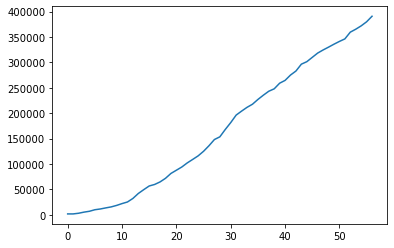

In [60]:
plt.plot(Pro_Revenue["Cumulative_Income"])

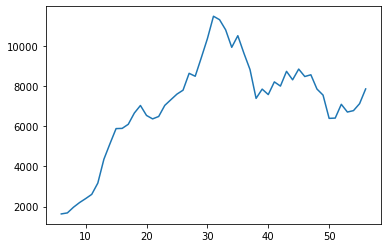

In [73]:
y = [Pro_Revenue["Total_Income"],Pro_Revenue['MA']]
plt.plot(Pro_Revenue['MA'])

In [65]:
Pro_Revenue['MA'] = Pro_Revenue["Total_Income"].rolling(window=7).mean()

In [67]:
Pro_Revenue

,Date,PENDLE_Transaction_Value,SPELL_Transaction_Value,xSDT_Transaction_Value,ALCX_Transaction_Value,BANK_Transaction_Value,FXS_Transaction_Value,FOX_Transaction_Value,SYN_Transaction_Value,XRUNE_Transaction_Value,...,PREMIA_Transaction_Value,ROOK_Transaction_Value,MTA_Transaction_Value,GRO_Transaction_Value,IQ_Transaction_Value,Total_Income,Cumulative_Income,Growth_Rate,Weekly_Growth_Rate,MA
0,2021-09-28,1768.105628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1768.105628,1768.105628,NaN,NaN,NaN
1,2021-09-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1768.105628,0.000000,NaN,NaN
2,2021-09-30,0.000000,0.000000,1290.360716,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1290.360716,3058.466344,0.729798,NaN,NaN
3,2021-10-01,574.367199,0.000000,523.500749,1118.949578,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2216.817526,5275.283869,0.724813,NaN,NaN
4,2021-10-02,394.711580,0.000000,510.191758,783.278670,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1688.182008,6963.465878,0.320017,NaN,NaN
5,2021-10-03,412.938109,0.000000,1009.576964,967.730405,0.636904,627.189552,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3018.071934,9981.537812,0.433415,NaN,NaN
6,2021-10-04,700.372462,0.000000,0.000000,790.072185,0.353484,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1490.798132,11472.335944,0.149356,NaN,1638.905135
7,2021-10-05,696.069404,0.000000,0.000000,888.510574,0.180438,533.917345,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2118.677762,13591.013705,0.184677,6.686766,1688.986868
8,2021-10-06,415.599957,0.000000,536.471851,624.651841,0.260767,393.355543,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1970.339959,15561.353664,0.144974,7.801145,1970.464005
9,2021-10-07,395.632299,0.000000,662.826178,1221.420076,0.240913,641.174915,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2921.294381,18482.648045,0.187728,5.043110,2203.454529


# Demand Analysis

In [74]:
discount_df = pd.read_csv("https://raw.githubusercontent.com/kinji20/crypto/main/Olympus_Dune_Output%20-%20Premium%20(1).csv")
discount_df

,Date,price,bond_price,discount,7_day_average
0,20-06-2021,313.37,290.21,8.01%,0.00%
1,21-06-2021,338.48,311.06,8.89%,0.00%
2,22-06-2021,295.72,279.59,5.76%,0.00%
3,23-06-2021,272.73,251.62,8.43%,0.00%
4,24-06-2021,285.91,267.24,7.04%,0.00%
...,...,...,...,...,...
159,26-11-2021,778.46,758.69,2.70%,2.56%
160,27-11-2021,725.57,701.89,3.47%,2.67%
161,28-11-2021,726.44,709.72,2.78%,2.74%
162,29-11-2021,774.62,749.41,3.56%,2.77%


In [75]:
apy_df = pd.read_csv("https://raw.githubusercontent.com/kinji20/crypto/main/Olympus_Dune_Output%20-%20APY.csv")
apy_df

,Date,avg_rebase,apy,5_Day_ROI
0,16-06-2021,0.007254,274302.05%,11.45%
1,17-06-2021,0.006953,197253.80%,10.95%
2,18-06-2021,0.006582,132588.62%,10.34%
3,19-06-2021,0.006350,102486.04%,9.96%
4,20-06-2021,0.006194,86484.36%,9.70%
...,...,...,...,...
163,26-11-2021,0.003913,7197.19%,6.03%
164,27-11-2021,0.003918,7235.42%,6.04%
165,28-11-2021,0.003907,7149.40%,6.02%
166,29-11-2021,0.003890,7021.92%,6.00%


# General Bond Sales Growth

In [138]:
bond_sales = token_data[(token_data["transaction_type"] == "stable_lp_outflow") | (token_data["transaction_type"] == "stable_outflow") | (token_data["transaction_type"] == "risk_outflow")]


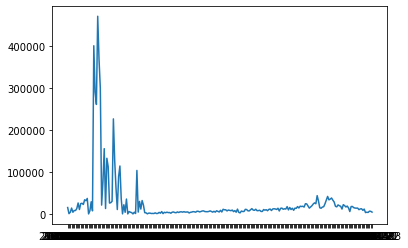

In [139]:
plt.plot(bond_sales.groupby("Date")["value"].sum())

In [140]:
bond_sales.groupby("Date")["value"].sum()

Date
2021-04-01    15295.470835
2021-04-02      731.120377
2021-04-03     3991.858433
2021-04-04    14005.330600
2021-04-05     4075.715219
                  ...     
2021-11-19     4207.200802
2021-11-20     3523.504825
2021-11-21     6635.691858
2021-11-22     6255.027203
2021-11-23     4349.777492
Name: value, Length: 234, dtype: float64

In [141]:
OHM_Dict["stable_lp_outflow"]["usd_value"] = OHM_Dict["stable_lp_outflow"]["value"] * OHM_Dict["stable_lp_outflow"]["open"]
OHM_Dict["stable_outflow"]["usd_value"] = OHM_Dict["stable_outflow"]["value"] * OHM_Dict["stable_outflow"]["open"]
OHM_Dict["risk_outflow"]["usd_value"] = OHM_Dict["risk_outflow"]["value"] * OHM_Dict["risk_outflow"]["open"]


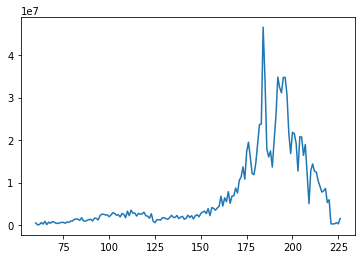

In [142]:
plt.plot(OHM_Dict["stable_lp_outflow"]["usd_value"][60:])

In [143]:
X = np.array(OHM_Dict["stable_lp_outflow"].index[60:]).reshape(-1,1)
y = OHM_Dict["stable_lp_outflow"]["usd_value"][60:].values
reg = LinearRegression().fit(X, y)
reg.coef_

array([112394.06626699])

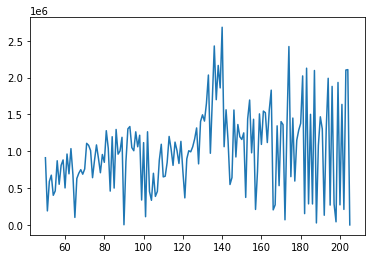

In [149]:
plt.plot(OHM_Dict["stable_outflow"]["usd_value"][50:])

In [145]:
X = np.array(OHM_Dict["stable_outflow"].index[60:]).reshape(-1,1)
y = OHM_Dict["stable_outflow"]["usd_value"][60:].values
reg = LinearRegression().fit(X, y)
reg.coef_

array([2625.65161726])

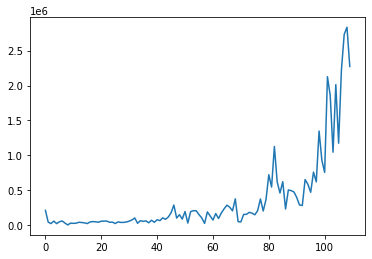

In [146]:
plt.plot(OHM_Dict["risk_outflow"]["usd_value"])

In [147]:
X = np.array(OHM_Dict["risk_outflow"].index[60:]).reshape(-1,1)
y = OHM_Dict["risk_outflow"]["usd_value"][60:].values
reg = LinearRegression().fit(X, y)
reg.coef_

array([38919.61202286])

In [137]:
OHM_Dict["risk_outflow"]

,Date,value,open,Sales_Growth,Weekly_Sales_Growth,Cumulative Sales,usd_value
0,2021-08-05,499.646225,422.820844,NaN,NaN,2.112608e+05,6.211090e+06
1,2021-08-06,94.520579,446.113321,-0.810825,NaN,2.534277e+05,2.880363e+05
2,2021-08-07,45.734656,475.298319,-0.516141,NaN,2.751653e+05,1.813463e+06
3,2021-08-08,123.783042,463.297439,1.706548,NaN,3.325137e+05,7.088126e+06
4,2021-08-09,46.993780,458.455690,-0.620354,NaN,3.540583e+05,2.839205e+06
...,...,...,...,...,...,...,...
105,2021-11-19,1621.278184,723.892132,-0.376236,0.072946,2.959460e+07,2.426983e+06
106,2021-11-20,2894.319302,765.956450,0.785208,1.719749,3.181153e+07,1.876064e+06
107,2021-11-21,3373.339196,810.125342,0.165503,2.964286,3.454435e+07,2.689559e+06
108,2021-11-22,3405.943713,832.345866,0.009665,0.423615,3.737928e+07,2.519485e+06


In [156]:
pd.set_option('display.max_rows', 500)
OHM_Dict["risk_outflow"][["Date","usd_value"]][60:]

,Date,usd_value
60,2021-10-05,7.248137e+04
61,2021-10-06,1.656702e+05
62,2021-10-07,9.463300e+04
63,2021-10-08,1.735509e+05
64,2021-10-09,2.338728e+05
65,2021-10-10,2.854978e+05
66,2021-10-11,2.567415e+05
67,2021-10-12,2.044854e+05
68,2021-10-13,3.758968e+05
69,2021-10-14,4.964757e+04


In [158]:
Pro_Revenue[["Date", 'Total_Income']]

,Date,Total_Income
0,2021-09-28,1768.105628
1,2021-09-29,0.000000
2,2021-09-30,1290.360716
3,2021-10-01,2216.817526
4,2021-10-02,1688.182008
5,2021-10-03,3018.071934
6,2021-10-04,1490.798132
7,2021-10-05,2118.677762
8,2021-10-06,1970.339959
9,2021-10-07,2921.294381
